Questions:
- how to vary the amount of solvent? if implicityl defined

In [90]:
import numpy as np
np.seterr(divide='ignore')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!
import matplotlib.cm as cm
import sys

#for data processing
import os
import operator
import xlrd

## Original ABsolution
2000 polymers
X_A-solvent = X_B-solvent = 0

F_a = 0.5, f_b = 0.5

In [91]:

# phi_path_orig = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/unedited/5.10.2021_ABsolution_ORIGINAL_rigid_kappa=20_24hrs/all_phis/"
# rephist_path_orig = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/unedited/5.10.2021_ABsolution_ORIGINAL_rigid_kappa=20_24hrs/finalrep.xlsx"
# r_path_orig = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/unedited/5.10.2021_ABsolution_ORIGINAL_rigid_kappa=20_24hrs/all_rs/"

## Original ABsolution
1000 polymers
X_A-solvent = X_B-solvent = 0

F_a = 0.5, f_b = 0.5

In [92]:

phi_path_orig = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/unedited/5.12.2021_ABsolution_ORIGINAL_rigid_kappa=20_1000poly_24hrs/all_phis/"
rephist_path_orig = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/unedited/5.12.2021_ABsolution_ORIGINAL_rigid_kappa=20_1000poly_24hrs/finalrep.xlsx"
r_path_orig = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/unedited/5.12.2021_ABsolution_ORIGINAL_rigid_kappa=20_1000poly_24hrs/all_rs/"

## Edited ABsolution
2000 polymers
X_A-B = X_B-solvent != 0

X_A-solv = 0

F_a = 0.5, f_b = 0.5

In [93]:

# phi_path_edit = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/edited/5.9.2021_ABsolution_EDITED_rigid_kappa=20_24hrs/all_phis/"
# rephist_path_edit = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/edited/5.9.2021_ABsolution_EDITED_rigid_kappa=20_24hrs/finalrep.xlsx"
# r_path_edit = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/edited/5.9.2021_ABsolution_EDITED_rigid_kappa=20_24hrs/all_rs/"

## Hanley 2000 
1000 polymers
X_ab = 0.08, X_a_solv = 0.4, X_B-solv = 0.4-1.0

N_m = 5


In [94]:
# base = "C:\\users/Thomas/wlcsim_membrane/data/AB_solution/three_chi/8.30.2021_Hanley_ABsolution_three_chis_flexible_diblock_Xbs_selective_solvent_36hrs/"
# phi_path_edit = base + "all_phis/"
# rephist_path_edit = base + "finalrep.xlsx"
# #r_path_edit = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/edited/5.9.2021_ABsolution_EDITED_rigid_kappa=20_24hrs/all_rs/"

1250 polymers X_ab = 0.08, X_a_solv = 0.4, X_B-solv = 0.4-1.0 N_m = 5

In [95]:
base = "C:\\users/Thomas/wlcsim_membrane/data/AB_solution/three_chi/9.20.2021_Hanley_ABsolution_1250poly_three_chis_flexible_Xbs_24hrs/"
phi_path_edit = base + "all_phis/"
rephist_path_edit = base + "finalrep.xlsx"


1500 polymers X_ab = 0.08, X_a_solv = 0.4, X_B-solv = 0.4-1.0 N_m = 5

In [96]:
# base = "C:\\users/Thomas/wlcsim_membrane/data/AB_solution/three_chi/9.19.2021_Hanley_ABsolution_1500poly_three_chis_flexible_Xbs_24hrs/"
# phi_path_edit = base + "all_phis/"
# rephist_path_edit = base + "finalrep.xlsx"


1750 polymers X_ab = 0.08, X_a_solv = 0.4, X_B-solv = 0.4-1.0 N_m = 5

In [97]:
# base = "C:\\users/Thomas/wlcsim_membrane/data/AB_solution/three_chi/9.16.2021_Hanley_ABsolution_1750poly_three_chis_flexible_Xbs_24hrs/"
# phi_path_edit = base + "all_phis/"
# rephist_path_edit = base + "finalrep.xlsx"


2000 polymers X_ab = 0.08, X_a_solv = 0.4, X_B-solv = 0.4-1.0
N_m = 5

In [98]:
# base = "C:\\users/Thomas/wlcsim_membrane/data/AB_solution/three_chi/9.15.2021_Hanley_ABmelt_flexible_Xbs_24hrs/"
# phi_path_edit = base + "all_phis/"
# rephist_path_edit = base + "finalrep.xlsx"


## QUALS 
Slide 18
2000 poly
X_ab = 2.0, X_a_solv = 0, X_B-solv = 0

N_m = 5


In [99]:
# base = "C:\\users/Thomas/wlcsim_membrane/data/AB_solution/three_chi/11.24.2021_ABsolution_three_chis_melt_DIBLOCK_qualsslide18_36hrs/"
# phi_path_edit = base + "all_phis/"
# rephist_path_edit = base + "finalrep.xlsx"


## QUALS 
Slide 18  FINAL!


2000 poly
X_ab = 2.0, X_a_solv = 0, X_B-solv = 0

N_m = 5


In [100]:
base = "C:\\users/Thomas/wlcsim_membrane/data/AB_solution/three_chi/11.30.2021_ABsolution_three_chis_melt_DIBLOCK_qualsslide18_FINAL_36hrs/"
phi_path_edit = base + "all_phis/"
rephist_path_edit = base + "finalrep.xlsx"



Slide 19
1000 poly
X_ab = 2.0, X_a_solv = 0, X_B-solv = 0

N_m = 5


In [101]:
# base = "C:\\users/Thomas/wlcsim_membrane/data/AB_solution/three_chi/11.26.2021_ABsolution_three_chis_1000poly_DIBLOCK_neutralsolv_qualsslide19_36hrs/"
# phi_path_edit = base + "all_phis/"
# rephist_path_edit = base + "finalrep.xlsx"


In [102]:
# '''PREPROCESSING:
# phi files- copy all into one folder
# get chi values from repHistory (copy last exchange into new notepad, import into excel, save)
# ''' 
# # load in phi files
# os.chdir(phi_path_orig)

# phi_df_list_orig = []
# v_val_list_orig = []
# for file in os.listdir():
#     file_path = f"{phi_path_orig}\{file}"
    
#     v_val = file_path[-2:]
#     if v_val[0] == "v":
#         v_val = v_val[1]
#     v_val = float(v_val) # smallest v = smallest chi
        
#     file_df = pd.read_csv(file_path, delimiter = "   |  -", names = ["Vol_A", "Vol_B"])
    
#     phi_df_list_orig.append([v_val, file_df])
#     v_val_list_orig.append(v_val)
#     del file_df

# phi_df_list_orig = sorted(phi_df_list_orig, key=operator.itemgetter(0))
# v_val_list_orig = sorted(v_val_list_orig)

# # load in rep history chis
# wb = xlrd.open_workbook(rephist_path_orig)
# ws = wb.sheet_by_index(0)
# chi_val_list_orig = ws.col_values(4)[1:]

In [103]:
'''PREPROCESSING:
phi files- copy all into one folder
get chi values from repHistory (copy last exchange into new notepad, import into excel, save)
''' 
# load in phi files
os.chdir(phi_path_edit)

phi_df_list_edit = []
v_val_list_edit = []
for file in os.listdir():
    file_path = f"{phi_path_edit}\{file}"
    
    v_val = file_path[-2:]
    if v_val[0] == "v":
        v_val = v_val[1]
    v_val = float(v_val) # smallest v = smallest chi
        
    file_df = pd.read_csv(file_path, delimiter = "   |  -", names = ["Vol_A", "Vol_B"])
    
    phi_df_list_edit.append([v_val, file_df])
    v_val_list_edit.append(v_val)
    del file_df

phi_df_list_edit = sorted(phi_df_list_edit, key=operator.itemgetter(0))
v_val_list_edit = sorted(v_val_list_edit)

# load in rep history chis
wb = xlrd.open_workbook(rephist_path_edit)
ws = wb.sheet_by_index(0)
chi_val_list_edit = ws.col_values(5)[1:]

<ipython-input-103-3550c981218a>:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  file_df = pd.read_csv(file_path, delimiter = "   |  -", names = ["Vol_A", "Vol_B"])


### Degree of mixing <phi_A* phi_B>

In [104]:
# phiA_B_list_orig = []
# for pair in phi_df_list_orig:
#     df_product = pair[1]["Vol_A"] * pair[1]["Vol_B"]
#     phiA_B = df_product.mean()
#     phiA_B_list_orig.append(phiA_B)

# #phiA_B_list_full_range = phiA_B_list


In [105]:
# phiA_B_sum_list_orig = np.array([])
# phiA_B_std_list_orig = np.array([])
# for pair in phi_df_list_orig:
#     df = pair[1]
#     df_product = df["Vol_A"] + df["Vol_B"]
#     df_product.hist(alpha=0.1, grid=False)
#     phiA_B_std_list_orig = np.append(phiA_B_std_list_orig, df_product.std(0))
#     phiA_B_sum = df_product.mean()
#     phiA_B_sum_list_orig = np.append(phiA_B_sum_list_orig, phiA_B_sum)
    
# plt.title("phi_polymer original")
# plt.xlabel("phi_poly")
# plt.ylabel("counts")

# #print(phiA_B_sum_list_ninth)
# print(phiA_B_std_list_orig.mean())
# #63 histograms ontop of each other (1 hist per replica)
# # each hist has 8000 values of a bin's phi total

In [106]:
phiA_B_list_edit = []
for pair in phi_df_list_edit:
    df_product = pair[1]["Vol_A"] * pair[1]["Vol_B"]
    phiA_B = df_product.mean()
    phiA_B_list_edit.append(phiA_B)

#phiA_B_list_full_range = phiA_B_list


0.08125621773901437


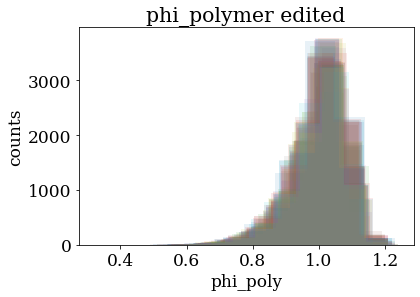

In [107]:
phiA_B_sum_list_edit = np.array([])
phiA_B_std_list_edit = np.array([])
for pair in phi_df_list_edit:
    df = pair[1]
    df_product = df["Vol_A"] + df["Vol_B"]
    df_product.hist(alpha=0.1, grid=False)
    phiA_B_std_list_edit = np.append(phiA_B_std_list_edit, df_product.std(0))
    phiA_B_sum = df_product.mean()
    phiA_B_sum_list_edit = np.append(phiA_B_sum_list_edit, phiA_B_sum)
    
plt.title("phi_polymer edited")
plt.xlabel("phi_poly")
plt.ylabel("counts")

#print(phiA_B_sum_list_ninth)
print(phiA_B_std_list_edit.mean())


In [108]:
chi_val_list_edit

[0.0,
 0.0333333,
 0.0666667,
 0.1,
 0.1333333,
 0.1666667,
 0.2,
 0.2333333,
 0.2666667,
 0.3,
 0.3333333,
 0.3666667,
 0.4,
 0.4333333,
 0.4666667,
 0.5,
 0.5333333,
 0.5666667,
 0.6,
 0.6333333,
 0.6666667,
 0.7,
 0.7333333,
 0.7666667,
 0.8,
 0.8333333,
 0.8666667,
 0.9,
 0.9333333,
 0.9666667,
 1.0,
 1.0333333,
 1.0666667,
 1.1,
 1.1333333,
 1.1666667,
 1.2,
 1.2333333,
 1.2666667,
 1.3,
 1.3333333,
 1.3666667,
 1.4,
 1.4333333,
 1.4666667,
 1.5,
 1.5333333,
 1.5666667,
 1.6,
 1.6333333,
 1.6666667,
 1.7,
 1.7333333,
 1.7666667,
 1.8,
 1.8333333,
 1.8666667,
 1.9,
 1.9333333,
 1.9666667,
 2.0]

Text(0.5, 0, 'X_bs*v_m')

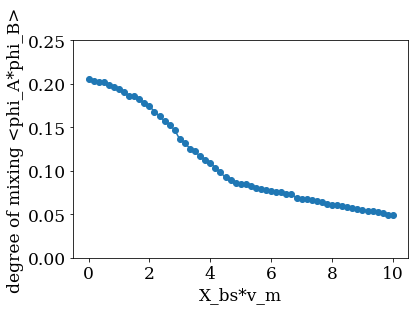

In [109]:
##### nondimensionalize x axis
#chi_vals_orig = np.array(chi_val_list_orig)
chi_vals_edit = np.array(chi_val_list_edit)
# bead_volume = 0.1 # simulation units
# monomer_volume = 5 * bead_volume
# chi = E/v_bead-> chi * vm = E/v_bead * (5 * v_bead) (E in terms of kTs!!)

#chi_v_m_orig = chi_vals_orig/0.2 
chi_v_m_edit = chi_vals_edit/0.2 

# original sim values
#plt.scatter(chi_v_m_orig, phiA_B_list_orig, color = "tab:orange")
#plt.plot(chi_v_m_orig, phiA_B_list_orig, label = "original", color = "tab:orange")

# edited im values
plt.scatter(chi_v_m_edit, phiA_B_list_edit, color = "tab:blue")
plt.plot(chi_v_m_edit, phiA_B_list_edit, label = "edited", color = "tab:blue")

plt.ylim((0, 0.25))
#plt.vlines(0.6562*5, 0, 0.25, color = "tab:blue")

# Estimating paper values
#chi_v_m_paper = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#phiA_B_paper = [0.231, 0.225, 0.217, 0.199, 0.178, 0.16, 0.143, 0.131, 0.122, 0.107, 0.094] #imageJ
#plt.scatter(chi_v_m_paper, phiA_B_paper, color = "tab:green")
#plt.plot(chi_v_m_paper, phiA_B_paper, label = "2017 soft matter", color = "tab:green")

#plt.vlines(3.1, 0, 0.25, color = "tab:blue")
#plt.vlines(8.71, 0, 0.25, color = "tab:red")
#plt.legend()
plt.ylabel("degree of mixing <phi_A*phi_B>")
plt.xlabel("X_bs*v_m")
# significant deviation from paper. kappa val/ lack of parallel tempering (too big of X interval)

### Heat capacity

In [110]:
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m


# slope_value=np.array([])
# x = chi_v_m_orig
# y = phiA_B_list_orig
# for i in range(len(y)-1):
#     i += 1
#     v=slope(x[i], y[i], x[i-1], y[i-1])
#     slope_value = np.append(slope_value, v)


In [111]:
# y_vals = slope_value*-1
# x_vals = chi_v_m_orig[1:]
# sigma = 0.45 #paper- std dv = 0.45

# smoothed_vals = np.zeros(len(y_vals)+1)
# for i, x_val in enumerate(x_vals):
#     kernel = np.exp(-(x_vals - x_val) ** 2 / (2 * sigma ** 2)) #gaussian centerd at each point
#     kernel = kernel / sum(kernel) #normalize
#     smoothed_vals[i] = sum(y_vals * kernel)
    
# plt.plot(x_vals, smoothed_vals[1:], color= "tab:orange")

# plt.vlines(3.1, -0.00, 0.024, color = "tab:blue") #post- kernel peaks, using image-J
# plt.vlines(8.71, -0.00, 0.018, color = "tab:red")
# plt.plot(chi_v_m_orig[1:], slope_value*-1, label = "5.3.21", color = "tab:orange", alpha=0.3)
# plt.ylabel("heat capacity")
# plt.xlabel("X*v_m")
# plt.title("original, 24hrs")

In [112]:
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m


slope_value=np.array([])
x = chi_v_m_edit
y = phiA_B_list_edit
for i in range(len(y)-1):
    i += 1
    v=slope(x[i], y[i], x[i-1], y[i-1])
    slope_value = np.append(slope_value, v)


In [113]:
lst = [0, 1, 2, 3, 4]
lst[0:-1]

[0, 1, 2, 3]

(0.0, 0.04)

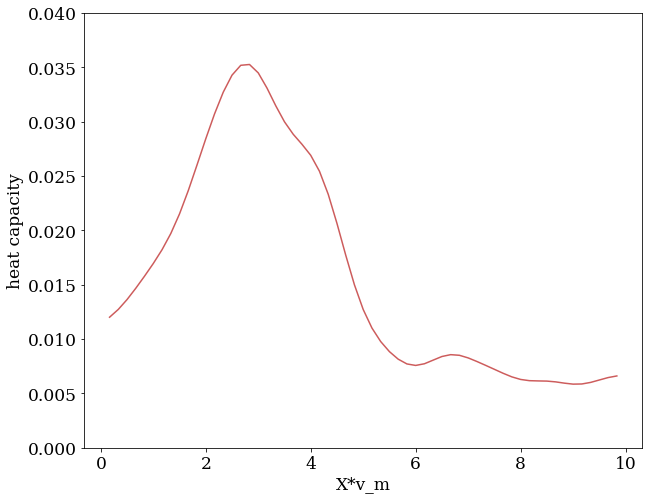

In [115]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 17}
plt.rc('font', **font)
y_vals = slope_value*-1
x_vals = chi_v_m_edit[1:]
sigma = 0.45 #paper- std dv = 0.45

smoothed_vals = np.zeros(len(y_vals)+1)
for i, x_val in enumerate(x_vals):
    kernel = np.exp(-(x_vals - x_val) ** 2 / (2 * sigma ** 2)) #gaussian centerd at each point
    kernel = kernel / sum(kernel) #normalize
    smoothed_vals[i] = sum(y_vals * kernel)
    
plt.plot(x_vals[:-1], smoothed_vals[1:-1], color= "indianred")

#plt.vlines(3.1, -0.00, 0.024, color = "tab:blue") #post- kernel peaks, using image-J
#plt.vlines(8.71, -0.00, 0.018, color = "tab:red")
#plt.plot(chi_v_m_edit[1:], slope_value*-1, label = "5.3.21", color = "tab:orange", alpha=0.3)
plt.ylabel("heat capacity")
plt.xlabel("X*v_m")
#plt.title("edited, 24hrs")
plt.ylim(0.00, 0.04)

In [34]:
for pair in phi_df_list_orig:
    del pair[1]
    del pair[0]
    del pair
del phi_df_list_orig

NameError: name 'phi_df_list_orig' is not defined

In [ ]:
for pair in phi_df_list_edit:
    del pair[1]
    del pair[0]
    del pair
del phi_df_list_edit

### Radius of gyration

In [18]:
class Bead:
    '''
    '''
    def __init__(self, x, y, z, bead_type):
        self.x = x
        self.y = y
        self.z = z
        self.bead_type = bead_type
    
    def print_bead(self):
        print("x: ", self.x)
        print("Y: ", self.y)
        print("Z: ", self.z)
        
class Polymer:
    '''
    '''
    
    def __init__(self, bead_list):
        self.bead_list = []
        self.bead_list = bead_list
        bead_coor_array = np.zeros((len(bead_list), 3))
        bead_types = np.zeros(len(bead_list))
        for i, bead in enumerate(bead_list):
            bead_coor_array[i, 0] = bead.x
            bead_coor_array[i, 1] = bead.y
            bead_coor_array[i, 2] = bead.z
            bead_types[i] = bead.bead_type
        self.bead_coor_array = bead_coor_array
        self.bead_types = bead_types
    
    def poly_print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
   
    def find_center_of_mass(self): 
        '''
        Find the center of mass for a given polymer chain wrt to a specific bead type
        '''
        #print("IN COM METHOD")
        X_bead = self.bead_coor_array[:,0]#[self.bead_types==bead_num] 
        Y_bead = self.bead_coor_array[:,1]#[self.bead_types==bead_num]
        Z_bead = self.bead_coor_array[:,2]#[self.bead_types==bead_num]
        
        x_center = np.mean(X_bead)
        y_center = np.mean(Y_bead)
        z_center = np.mean(Z_bead)
        
        #print("COM: ", [x_center,y_center,z_center])
        return [x_center,y_center,z_center]
    
#     def find_rg2(self): # INCORRECT- need to divid by total num of beads
#         center_of_mass = self.find_center_of_mass()
#         displacements = self.bead_coor_array - center_of_mass
#         displacements_square = np.square(displacements)
#         final_disp = np.sum(displacements_square, axis=1) #final disp square of sub polymer beads
        
#         radius_g_2 = np.sum(final_disp)
        
#         return radius_g_2
    
    def Radius_of_gyration_2(self):
        center_of_mass_point = self.find_center_of_mass()
        X_bead = self.bead_coor_array[:,0]#[self.bead_types==bead_num] 
        Y_bead = self.bead_coor_array[:,1]#[self.bead_types==bead_num]
        Z_bead = self.bead_coor_array[:,2]#[self.bead_types==bead_num]
        
        n = X_bead.shape[0]
        Rg2 = (np.sum((X_bead - center_of_mass_point[0])**2 + 
                    (Y_bead - center_of_mass_point[1])**2 + (Z_bead - center_of_mass_point[2])**2)/n)
        #print("IN RADIUG OF GYR METHOD")
        #print("Rg2:", Rg2)
        return Rg2
    
class PolymerNetwork:
    """
    This represents the postions of bead and their type (time invariant)
    
    Parameters
    ----------
    X : float [array] X 
    """
    
    def __init__(self,X,Y,Z, Beads, beads_per_polymer=40, persistence_length=2.03):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.Beads = Beads
        self.beads_per_polymer = beads_per_polymer
        self.bead_list = []
        self.polymer_list = []
        self.persistence_length = persistence_length
        self.create_beads()
        self.create_polymers()
        
        self.density = Beads.shape[0]/((max(X)-min(X)) * (max(Y)-min(Y)) * (max(Z)-min(Z)))
        
    def visualize(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(self.X[self.Beads==0], self.Y[self.Beads==0], self.Z[self.Beads==0],color='y')
        ax.scatter3D(self.X[self.Beads==1], self.Y[self.Beads==1], self.Z[self.Beads==1],color='r')
        ax.scatter3D(self.X[self.Beads==2], self.Y[self.Beads==2], self.Z[self.Beads==2],color='b')
        
    def nearest_neighbor(self,bead_num,radius):
        '''
        Find the average number of beads that surround a bead of the same type within the radius specified
        '''
        X_bead = self.X[Beads==bead_num]
        Y_bead = self.Y[Beads==bead_num]
        Z_bead = self.Z[Beads==bead_num]
        
        total_neighbors = 0
        for i in range(Beads[Beads==bead_num].shape[0]):
            point = np.array([X_bead[i],Y_bead[i],Z_bead[i]])
            displacement = np.sqrt((X_bead - point[0])**2 + (Y_bead - point[1])**2 + (Z_bead - point[2])**2)
            num_neighbor_points = displacement[displacement<=radius].shape[0] -1
            
            total_neighbors += num_neighbor_points

        return total_neighbors/(i+1)
    
    def create_beads(self):
        #if not hasattr(self, "bead_list"):
        if len(self.bead_list) == 0:
            for i in range(len(self.X)):
                bead = Bead(self.X[i], self.Y[i], self.Z[i], self.Beads[i])
                self.bead_list.append(bead)
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
    
    def create_polymers(self):
        #if not hasattr(self, "polymer_list") and hasattr(self, "bead_list"):
        if len(self.polymer_list) == 0 and len(self.bead_list) > 0:
            for i in range(self.beads_per_polymer, len(self.bead_list) + 1, self.beads_per_polymer):
                polymer = Polymer(self.bead_list[i - self.beads_per_polymer : i])
                self.polymer_list.append(polymer)
        
    def print_polymer_list(self, verbose=False):
        for i, poly in enumerate(self.polymer_list):
            print("POLYMER " + str(i))
            if verbose:
                poly.print_bead_list()
# '''
# Finds all posible percolation paths in the polylmer network, then plots them. Color indicates the number of beads in 
# the path
# '''
    def visualize_percolation_paths(self,connection_radius, x_lim = 1, y_lim = 1, z_lim = 1, bead_num=0):
        #NEED TO MAKE MUCH FASTER!!!
        X_bead = self.X[self.Beads==bead_num]
        Y_bead = self.Y[self.Beads==bead_num]
        Z_bead = self.Z[self.Beads==bead_num]
        
        #Build array to see if a bead has been used in a percolation collection yet (True means it hasn't been used)
        ALL_PATHS = []  

        
#         bead = self.bead_list[4]
#         starting_path = PercolationPath([bead])
#         self.find_all_percolation_paths(starting_path, connection_radius, bead_num=0)
#         #print("beads in path: ", starting_path.print_path())
#         ALL_PATHS.append(starting_path)

        ALL_PATHS = self.find_all_percolation_paths(connection_radius, bead_num)
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        #print(len(ALL_PATHS))
        max_path = PercolationPath([])
        max_length = 0
        
        for path in ALL_PATHS:
            if len(path.beads_in_path) > len(max_path.beads_in_path):
                max_path = path
                max_length = len(max_path.beads_in_path)
            
        for path in ALL_PATHS:
            color = cm.rainbow(len(path.beads_in_path)/max_length - .01)
            path.make_bead_coor_array()
            X_vals = path.bead_coor_array[:, 0]
            Y_vals = path.bead_coor_array[:, 1]
            Z_vals = path.bead_coor_array[:, 2]
            ax.scatter3D(X_vals, Y_vals, Z_vals, color=color)
        plt.xlim([0, x_lim])
        plt.ylim([0, y_lim])
        ax.set_zlim(0, z_lim)
        return len(ALL_PATHS)

# '''
# Finds all posible percolation paths within the polymer network. 
# Returns a list of percolation paths, which contain the list of beads in the given path
# '''
    def find_all_percolation_paths(self, connection_radius, bead_num=0):
        all_paths = []
        pathed_beads = []
        for i, bead in enumerate(self.bead_list): # try all beads as starting bead to find percoaltion path
            if i % 10000 == 0: # to monitor progress
                print("on bead: ", i)
                print("pathed_beads", len(pathed_beads))
            if (bead not in pathed_beads) and (bead.bead_type == bead_num): # no repeat beads
                starting_path = PercolationPath([bead])
                self.find_percolation_path(starting_path, connection_radius, bead_num)
                #print("beads in path: ", starting_path.print_path())
                all_paths.append(starting_path)
                #print("old length of pathed beads", len(pathed_beads))
                pathed_beads += starting_path.beads_in_path
                #print("new length of pathed beads", len(pathed_beads))
                
        return all_paths

# '''
# Recursively finds a single percolation path given a current path with at least on bead in it.
# Modifies current_path in place to be updated with all beads that make up a percolation path
# '''    
    def find_percolation_path(self, current_path, connection_radius, bead_num):
        last_bead = current_path.beads_in_path[-1]
        avail_beads = self.find_available_beads(last_bead, connection_radius, bead_num)
        #print("Last bead")
        #print(last_bead.print_bead())
        #print("Avail beads:")
        #for bead in avail_beads:
            #bead.print_bead()
        #base case- avail beads is empty, then do nothing
        
        #recursive case:
        for bead in avail_beads:
            if bead not in current_path.beads_in_path:
                #print("efore adding bead: ", current_path.print_path)
                current_path.beads_in_path.append(bead)
                #print("after adding bead: ", current_path.print_path)
                self.find_percolation_path(current_path, connection_radius, bead_num)
            #return current_path
        
# '''
# Finds all beads that are within the connection radius and have the given bead number
# '''        
    def find_available_beads(self, bead, connection_radius, bead_num):
        #print("stuck on avail beads?")
        available_beads = []
        displacement = np.sqrt((self.X - bead.x)**2 + (self.Y - bead.y)**2 + (self.Z - bead.z)**2)
        neighbor_beads_index = np.where([displacement<=connection_radius])[1]
        #print("neighbor_beads indices", neighbor_beads_index)
        #NEED TO FIND, OF THESE NEIGHBOR BEADS, WHICH IS THE FURTHEST??
        for j in neighbor_beads_index:
            neighbor_bead = self.bead_list[j]
            if neighbor_bead.bead_type == bead_num:
                available_beads.append(neighbor_bead)
                
        return available_beads
    '''
    find <r_g^2> for full lenght polymers in the network
    '''
    def find_rg2(self):
        rad_g = np.array([])
        for i, poly in enumerate(self.polymer_list):
            rad_g = np.append(rad_g, poly.Radius_of_gyration_2())
        return np.average(rad_g)

In [19]:
'''PREPROCESSING:
r files- copy all into one folder
get chi values from same repHistory (copy last exchange into new notepad, import into excel, save)
'''
  
# Change the directory
os.chdir(r_path_orig)

r_df_list_orig = []
v_val_list_orig = []
for file in os.listdir():
    file_path = f"{r_path_orig}\{file}"
    
    v_val = file_path[-2:]
    if v_val[0] == "v":
        v_val = v_val[1]
    v_val = float(v_val) # smallest v = smallest chi
    name_list = ["X", "Y", "Z", "Type"]        
    file_df = pd.read_csv(file_path, names = name_list, delim_whitespace=True)#, delimiter = " ")#
    
    r_df_list_orig.append([v_val, file_df])
    v_val_list_orig.append(v_val)
    del file_df
r_df_list_orig = sorted(r_df_list_orig, key=operator.itemgetter(0))
v_val_list_orig = sorted(v_val_list_orig)

wb = xlrd.open_workbook(rephist_path_orig)
ws = wb.sheet_by_index(0)
chi_val_list_orig = ws.col_values(4)[1:]

In [20]:
rg2_orig = []
for i, pair in enumerate(r_df_list_orig):
    df = pair[1]
    poly_net = PolymerNetwork(df.X.values, df.Y.values, df.Z.values, df.Type.values, beads_per_polymer=40)   
    rg2_orig.append(poly_net.find_rg2())
    del poly_net

did 0
did 1
did 2
did 3
did 4
did 5
did 6
did 7
did 8
did 9
did 10
did 11
did 12
did 13
did 14
did 15
did 16
did 17
did 18
did 19
did 20
did 21
did 22
did 23
did 24
did 25
did 26
did 27
did 28
did 29
did 30
did 31
did 32
did 33
did 34
did 35
did 36
did 37
did 38
did 39
did 40
did 41
did 42
did 43
did 44
did 45
did 46
did 47
did 48
did 49
did 50
did 51
did 52
did 53
did 54
did 55
did 56
did 57
did 58
did 59
did 60
did 61


(18.8, 19.12)

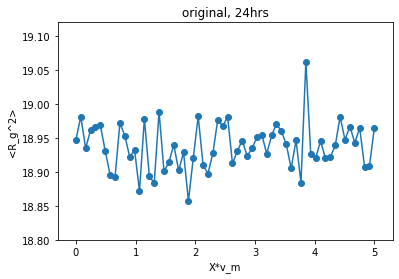

In [21]:
chi_vals_orig = np.array(chi_val_list_orig)
chi_v_m_orig = chi_vals_orig/0.2
plt.plot(chi_v_m_orig, rg2_orig)
plt.scatter(chi_v_m_orig, rg2_orig)
plt.ylabel("<R_g^2>")
plt.xlabel("X*v_m")
plt.title("original, 24hrs")
plt.ylim((18.8, 19.12))
#avg over 1000 polymers in each replica

In [22]:
'''PREPROCESSING:
r files- copy all into one folder
get chi values from same repHistory (copy last exchange into new notepad, import into excel, save)
'''
  
# Change the directory
os.chdir(r_path_edit)

r_df_list_edit = []
v_val_list_edit = []
for file in os.listdir():
    file_path = f"{r_path_edit}\{file}"
    
    v_val = file_path[-2:]
    if v_val[0] == "v":
        v_val = v_val[1]
    v_val = float(v_val) # smallest v = smallest chi
    name_list = ["X", "Y", "Z", "Type"]        
    file_df = pd.read_csv(file_path, names = name_list, delim_whitespace=True)#, delimiter = " ")#
    
    r_df_list_edit.append([v_val, file_df])
    v_val_list_edit.append(v_val)

r_df_list_edit = sorted(r_df_list_edit, key=operator.itemgetter(0))
v_val_list_edit = sorted(v_val_list_edit)

wb = xlrd.open_workbook(rephist_path_edit)
ws = wb.sheet_by_index(0)
chi_val_list_edit = ws.col_values(4)[1:]

In [ ]:
rg2_edit = []
for i, pair in enumerate(r_df_list_edit):
    df = pair[1]
    poly_net = PolymerNetwork(df.X.values, df.Y.values, df.Z.values, df.Type.values, beads_per_polymer=40)   
    rg2_edit.append(poly_net.find_rg2())

In [ ]:
chi_vals_edit = np.array(chi_val_list_edit)
chi_v_m_edit = chi_vals_edit/0.2
plt.plot(chi_v_m_edit, rg2_edit)
plt.scatter(chi_v_m_edit, rg2_edit)
plt.ylabel("<R_g^2>")
plt.xlabel("X*v_m")
plt.title("edited, 24hrs")
plt.ylim((18.8, 19.12))
#avg over 1000 polymers in each replica